##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Browser as a tool

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Browser_as_a_tool.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

LLMs are powerful tools, but are not intrinsically connected to live data sources. Features like Google Search grounding provide fresh information using Google's search index, but to supply truly live information, you can connect a browser to provide up-to-the-minute data and smart exploration.

This notebook will guide you through three examples of using a browser as a tool with the Gemini API, using both the [Live Multimodal API](https://ai.google.dev/api/multimodal-live) and traditional turn-based conversations.

* Requesting live data using a browser tool with the Live API
* Returning images of web pages from function calling
* Connecting to a local network/intranet using a browser tool

**Note**: for most of the use-cases, you can use the tools directly by Gemini to get it to search content using Google Search, grab videos from YouTube or fetch context from URLs without having to set-up anything. Check out the [Grounding](https://colab.research.google.com/quickstarts/Grounding.ipynb) notebook for more details.


## Set up the SDK

This guide uses the [`google-genai`](https://pypi.org/project/google-genai) Python SDK to connect to the Gemini models.

In [41]:
%pip install -U -q 'google-genai'

from google import genai
genai.__version__

'1.48.0'

### Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/gemini-api-cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [42]:
import os
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

### Create the SDK client

You will use the same `client` instance for both the Live API and the classic REST API interactions, so define models for each.

In [43]:
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

LIVE_MODEL = 'gemini-2.0-flash-live-001'  # @param ['gemini-2.0-flash-live-001', 'gemini-live-2.5-flash-preview', 'gemini-2.5-flash-preview-native-audio-dialog', 'gemini-2.5-flash-exp-native-audio-thinking-dialog'] {allow-input: true, isTemplate: true}
MODEL = 'gemini-2.5-flash'  # @param ['gemini-2.5-flash'] {allow-input: true, isTemplate: true}

### Define some helpers

The `show_parts` helper renders the deeply nested output that the API returns in an notebook-friendly way; handling text, code and tool calls.

The `can_crawl_url` helper will perform a [`robots.txt`](https://developers.google.com/search/docs/crawling-indexing/robots/intro) check to ensure any automated requests are welcome by the remote service.

In [44]:
import json
from urllib.robotparser import RobotFileParser
from urllib.parse import urlparse

from IPython.display import display, HTML, Markdown


def show_parts(r: types.GenerateContentResponse) -> None:
  """Helper for rendering a GenerateContentResponse object in IPython."""
  parts = r.candidates[0].content.parts
  if parts is None:
    finish_reason = r.candidates[0].finish_reason
    print(f'{finish_reason=}')
    return

  for part in parts:
    if part.text:
      display(Markdown(part.text))
    elif part.executable_code:
      display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    else:
      print(json.dumps(part.model_dump(exclude_none=True), indent=2))

  grounding_metadata = r.candidates[0].grounding_metadata
  if grounding_metadata and grounding_metadata.search_entry_point:
    display(HTML(grounding_metadata.search_entry_point.rendered_content))


def can_crawl_url(url: str, user_agent: str = "*") -> bool:
    """Look up robots.txt for a URL and determine if crawling is permissable.

    Args:
        url: The full URL to check.
        user_agent: The user agent to check, defaults to any UA.

    Returns:
        True if the URL can be crawled, False otherwise.
    """
    try:
      parsed_url = urlparse(url)
      robots_url = f"{parsed_url.scheme}://{parsed_url.netloc}/robots.txt"
      rp = RobotFileParser(robots_url)
      rp.read()

      return rp.can_fetch(user_agent, url)

    except Exception as e:
      print(f"Error checking robots.txt: {e}")
      return False  # Be a good citizen: fail closed.

## Browsing live

This example will show you how to use the Multimodal Live API with the Google Search tool, and then comparatively shows a custom web browsing tool to retrieve site contents in real-time.


### Use Google Search as a tool

The streaming nature of the Live API requires that the stream processing and function handling code be written in advance. This allows the stream to continue without timing out.

This example uses text as the input mode, and streams text back out, but the technique applies any mode supported by the Live API, including audio.

In [45]:
config = {
    'response_modalities': ['TEXT'],
    'tools': [
        {'google_search': {}},
    ],
}


async def stream_response(stream, *, tool=None):
  """Handle a live streamed response, printing out text and issue tool calls."""
  all_responses = []

  async for msg in stream.receive():
    all_responses.append(msg)

    if text := msg.text:
      # Print streamed text responses.
      print(text, end='')

    elif tool_call := msg.tool_call:
      # Handle tool calls.
      for fc in tool_call.function_calls:
        print(f'< Tool call', fc.model_dump(exclude_none=True))

        if tool:
          # Call the tool.
          assert fc.name == tool.__name__, "Unknown tool call encountered"
          tool_result = tool(**fc.args)

        else:
          # Return 'ok' as a way to mock tool calls.
          tool_result = 'ok'

        tool_response = types.LiveClientToolResponse(
            function_responses=[types.FunctionResponse(
                name=fc.name,
                id=fc.id,
                response={'result': tool_result},
            )]
        )

        await stream.send(input=tool_response)

  return all_responses


Now define and run the conversation.

In [46]:
async def run():
  async with client.aio.live.connect(model=LIVE_MODEL, config=config) as stream:

    await stream.send(input="What is today's featured article on the English Wikipedia?", end_of_turn=True)
    await stream_response(stream)

await run()

The featured article on the English Wikipedia for November 4, 2025, is the 2019 Champion of Champions snooker tournament. The summary on the main page says that the 2019 Women's World Champion competed at the tournament for the first time. As an invitational event, the Champion of Champions tournament carried no world-ranking points. Ronnie O'Sullivan was the defending champion having defeated Kyren Wilson 10–9 in the final of the 2018 event. O'Sullivan lost 5–6 to Neil Robertson in the semi-finals. Robertson defeated reigning world champion Judd Trump 10–9 in the final to win the championship, having required foul shots in the penultimate frame to avoid losing the match.


Depending on when you run this, you may note a discrepency between what Google Search has in its index, and what is currently live on Wikipedia. Check out [Wikipedia's featured article](https://en.wikipedia.org/wiki/Main_Page#mp-tfa) yourself. Alternatively, the model may decide not to answer due to the requirement for freshness.

To improve this situation, add a browse tool so the model can acquire this information in real-time.

### Add a live browser

This step defines a "browser" that requests a URL over HTTP(S), converts the response to markdown and returns it.

This technique works for sites that serve content as full HTML, so sites that rely on scripting to serve content, such as a [PWA](https://developer.mozilla.org/en-US/docs/Web/Progressive_web_apps) without [SSR](https://developer.mozilla.org/en-US/docs/Glossary/SSR), will not work. Check out the visual example later that uses a fully-featured browser.

In [47]:
%pip install -q markdownify

In [54]:
import requests

import markdownify


def load_page(url: str) -> str:
  """
  Load the page contents as Markdown.
  """

  if not can_crawl_url(url):
    return f"URL {url} failed a robots.txt check."

  try:
    page = requests.get(url)
    return markdownify.markdownify(page.content)

  except Exception as e:
    return f"Error accessing URL: {e}"


Now define and run the conversation using the new tool. Here an extended system instruction has been added to coerce the model into calling the tool immediately, so that it doesn't engage in an open-ended conversation that's hard to demonstrate in a notebook.

In [55]:
import warnings

warnings.filterwarnings('ignore')
# warnings.formatwarning()


In [56]:
load_page_def = types.Tool(functionDeclarations=[
    types.FunctionDeclaration.from_callable(client=client, callable=load_page)]).model_dump(exclude_none=True)

config = {
    'response_modalities': ['TEXT'],
    'tools': [
        load_page_def,
    ],
    'system_instruction': """Your job is to answer the users query using the tools available.

First determine the address that will have the information and tell the user. Then immediately
invoke the tool. Then answer the user.
"""
}


async def run():
  async with client.aio.live.connect(model=LIVE_MODEL, config=config) as stream:

    await stream.send(input="What is today's featured article on the English Wikipedia?", end_of_turn=True)
    await stream_response(stream, tool=load_page)

await run()

I can find the current featured article on the English Wikipedia by accessing its main page. The

 URL for that is "https://en.wikipedia.org/wiki/Main_Page".
< Tool call {'id': 'function-call-3026737770335397956', 'args': {'url': 'https://en.wikipedia.org/wiki/Main_Page'}, 'name': 'load_page'}


I am sorry, I was unable to retrieve the content from the Wikipedia main page due to a robots.txt check failure. I cannot directly answer your question.


## Browse pages visually

In the previous example, you used a tool to retrieve a page's textual content and use it in a live chat context. However, web pages are a rich multi-modal medium, so using text results in some loss of signal. Using a fully-featured web browser also enables websites that use JavaScript to render content, something that is not possible using a simple HTTP request like the earlier example.

In this example, you will define a tool that takes a screenshot of a web page and passes the image back to the model.

Note: This example automates a headless Chromium browser, so the instructions are specific to a Linux environment and will run on Google Colab. Try this example on Colab, or check out the [Selenium documentation](https://www.selenium.dev/documentation/webdriver/browsers/) for setting up specific browsers in your environment.

In [57]:
!apt install -y chromium-browser

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apparmor libfuse3-3 libudev1 snapd squashfs-tools systemd-hwe-hwdb udev
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser libfuse3-3 snapd squashfs-tools systemd-hwe-hwdb
  udev
The following packages will be upgraded:
  libudev1
1 upgraded, 7 newly installed, 0 to remove and 40 not upgraded.
Need to get 34.1 MB of archives.
After this operation, 134 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 apparmor amd64 3.0.4-2ubuntu2.4 [598 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 squashfs-tools amd64 1:4.5-3build1 [159 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libudev1 amd64 249.11-0ubuntu3.17 [76.7 kB]
Get:4 http://archive.ubuntu.com/

In [58]:
%pip install -q selenium webdriver-manager

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.0/512.0 kB 34.0 MB/s eta 0:00:00


### Define a graphical browser

Here you define a `browse_url` function that uses [Selenium](https://selenium-python.readthedocs.io/) to load a headless web browser, navigate to a URL and take a screenshot. This technique takes a single screenshot at a fixed size. There are other tools, such as [`selenium-screenshot`](https://pypi.org/project/selenium_screenshot), that can capture full-length images by repeatedly scrolling and capturing the page. As this tool is intended for use during a live conversation, this example uses the faster single-shot approach.

In [59]:
import time
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

SCREENSHOT_FILE = 'screenshot.png'


def browse_url(url: str) -> str:
    """Captures a screenshot of the webpage at the provided URL.

    A graphical browser will be used to connect to the URL provided,
    and generate a screenshot of the rendered web page.

    Args:
        url: The full absolute URL to browse/screenshot.

    Returns:
        "ok" if successfully captured, or any error messages.
    """
    if not can_crawl_url(url):
      return f"URL {url} failed a robots.txt check."

    try:
      chrome_options = webdriver.ChromeOptions()
      chrome_options.add_argument('--headless')
      chrome_options.add_argument('--no-sandbox')
      chrome_options.headless = True
      driver = webdriver.Chrome(options=chrome_options)

      # Take one large image, 2x high as it is wide. This should be enough to
      # capture most of a page's interesting info, and should capture anything
      # designed "above the fold", without going too deep into things like
      # footer links, infinitely scrolling pages, etc.
      # Otherwise multiple images are needed, which requires waiting, scrolling
      # and stitching, and introduces lag that slows down interactions.
      driver.set_window_size(1024, 2048)
      driver.get(url)

      # Wait for the page to fully load.
      time.sleep(5)
      driver.save_screenshot(SCREENSHOT_FILE)

      print(f"Screenshot saved to {SCREENSHOT_FILE}")
      return markdownify.markdownify(driver.page_source)

    except Exception as e:
      print(f"An error occurred: {e}")
      return str(e)

    finally:
      # Close the browser
      if driver:
        driver.quit()


url = "https://en.wikipedia.org/wiki/Castle"
browse_url(url);

Check out the screenshot to make sure it worked.

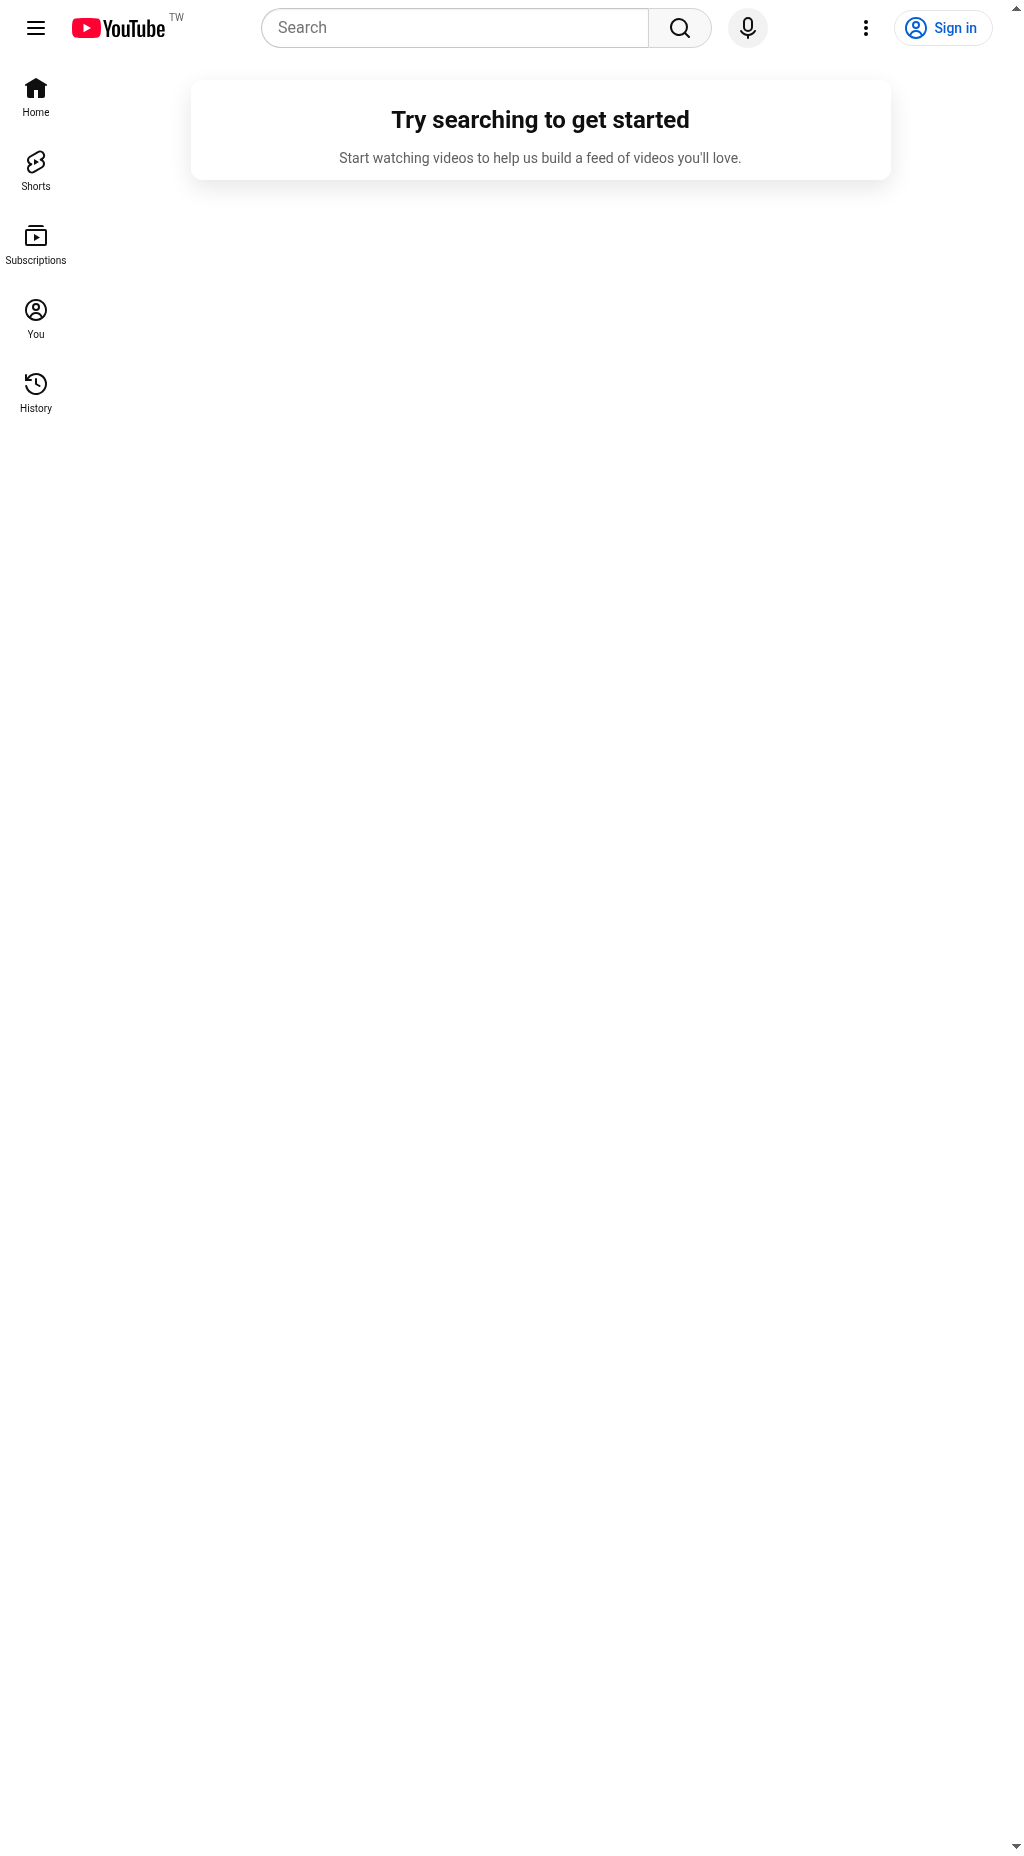

In [65]:
from IPython.display import Image

Image('screenshot.png')

### Connect the browser to the model

Add the `browse_url` tool to a model and start a chat session. As LLMs do not directly have internet connectivity, modern models like Gemini are trained to tell users that they can't access the internet, rather than hallucinating results. To override this behaviour, this step adds a system instruction that guides the model to use the tool for internet access.

In [60]:
sys_int = """You are a system with access to websites via the `browse_url` tool.
Use the `browse_url` tool to browse a URL and generate a screenshot that will be
returned for you to see and inspect, like using a web browser.

When a user requests information, first use your knowledge to determine a specific
page URL, tell the user the URL and then invoke the `browse_tool` with this URL. The
tool will supply the website, at which point you will examine the contents of the
screenshot to answer the user's questions. Do not ask the user to proceed, just act.

You will not be able to inspect the page HTML, so determine the most specific page
URL, rather than starting navigation from a site's homepage.
"""

# Because `browse_url` generates an image, and images can't be used in function calling
# (but can be used in regular Content/Parts), automatic function calling can't be used and
# the tool must be specified explicitly, and handled manually.
browse_tool = types.Tool(functionDeclarations=[
    types.FunctionDeclaration.from_callable(client=client, callable=browse_url)])

chat = client.chats.create(
    model=MODEL,
    config={'tools': [browse_tool], 'system_instruction': sys_int})

r = chat.send_message('What is trending on YouTube right now?')
show_parts(r)

I will browse the YouTube trending page at https://www.youtube.com/feed/trending.

{
  "function_call": {
    "args": {
      "url": "https://www.youtube.com/feed/trending"
    },
    "name": "browse_url"
  }
}


You should see a `function_call` in the response above. Once the model issues a function call, execute the tool and save both the `function_response` and the image for the next turn.

If you do not see a `function_call`, you can either re-run the cell, or continue the chat to answer any questions the model has (e.g. `r = chat.send_message('Yes, please use the tool')`).

In [67]:
import PIL
import PIL.Image
response_parts = []

# For each function call, generate the response in two parts. Once for the
# function response, and one for the image as regular content. This simulates
# the function "returning" an image to the model as part of a function call.
for p in r.candidates[0].content.parts:
  if fn := p.function_call:
    assert fn.name == 'browse_url'

    url = fn.args['url']
    print(url)
    response = browse_url(url)
    # print(response)

    img = PIL.Image.open(SCREENSHOT_FILE)

    fr = genai.types.Part(function_response=genai.types.FunctionResponse(
        name=fn.name,
        id=fn.id,
        response={'result': response},
    ))
    response_parts.extend([fr, img])

https://www.youtube.com/feed/trending
Screenshot saved to screenshot.png


Inspect the image before it is sent back to the model. Depending on where you are running this, you may see localised content. If you are using Google Colab, you can run `!curl ipinfo.io` to see the geolocation of the running kernal.

Note that if you see a semi-blank image, the page may not have fully loaded. Try adjusting the `time.sleep` in `browse_url`, or provide a suitable implementation for the pages you are using in your application.

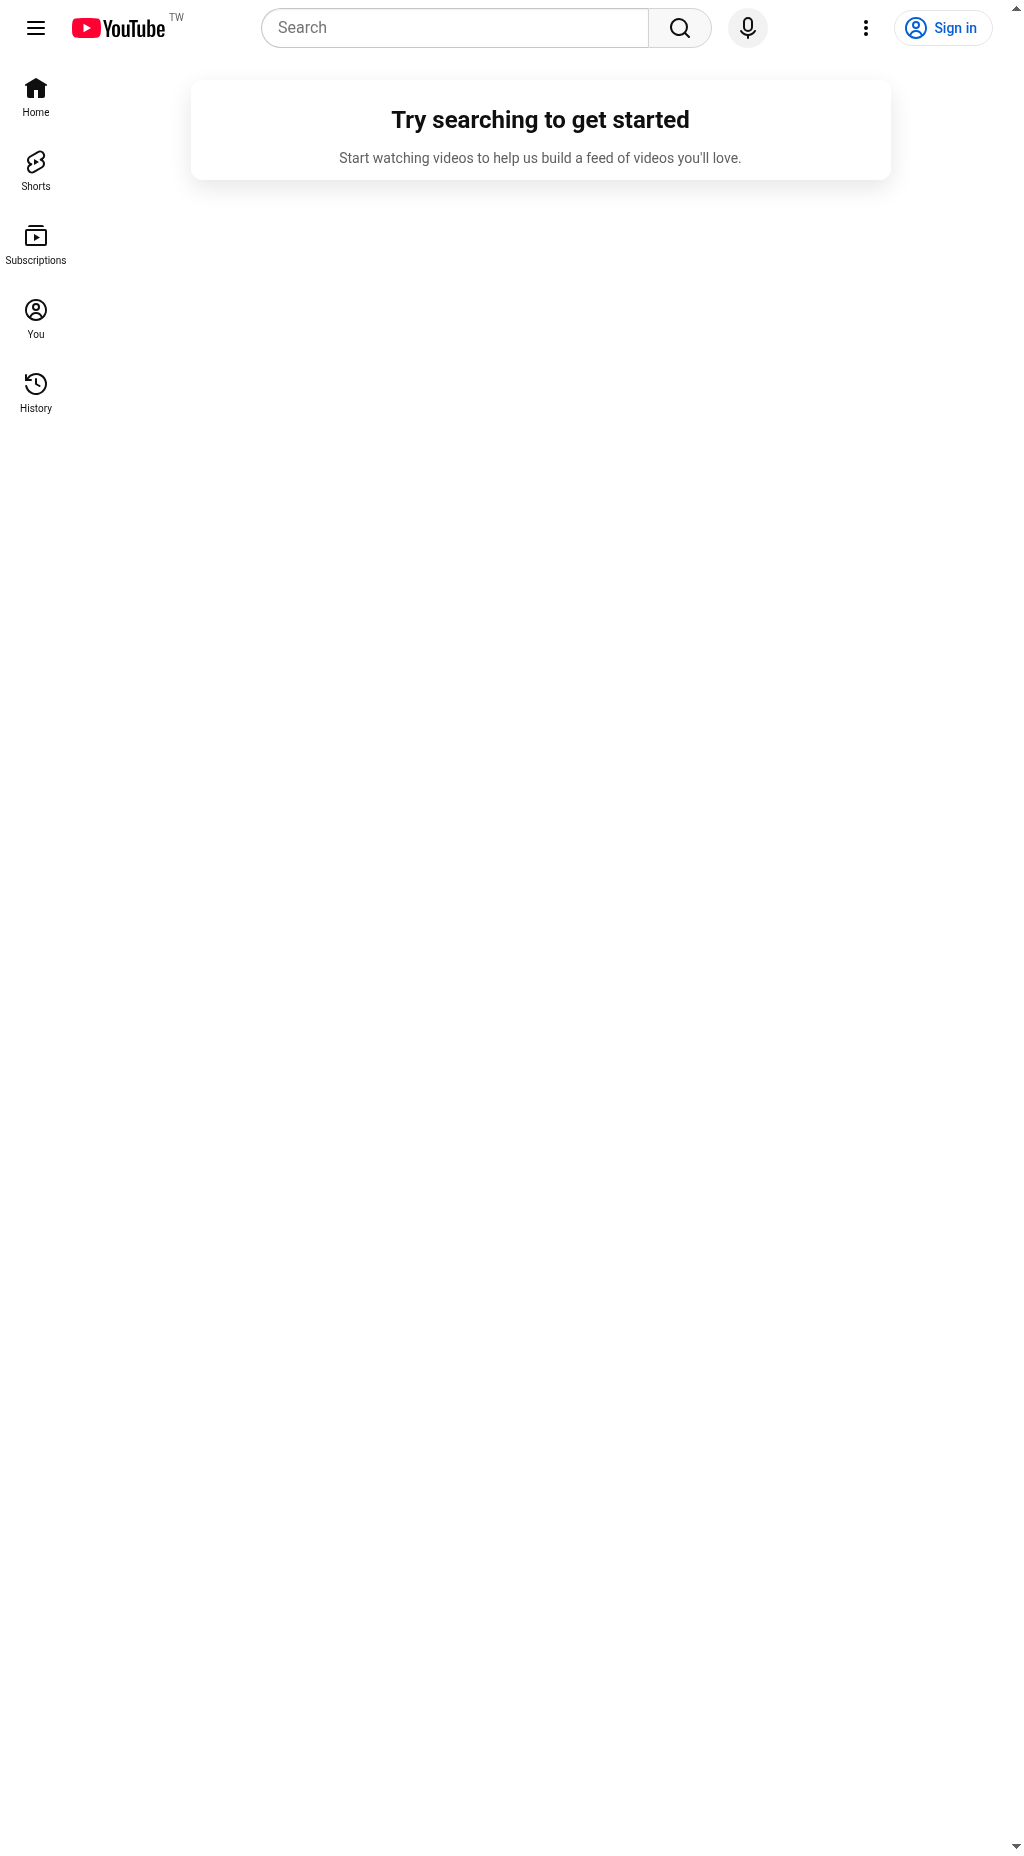

In [68]:
Image(SCREENSHOT_FILE)

In [69]:
r2 = chat.send_message(response_parts)
show_parts(r2)

thought
The `browse_url` tool returned a screenshot of the YouTube trending page, but it appears to be blank with a message "Try searching to get started" and "Start watching videos to help us build a feed of videos you'll love." This indicates that the trending feed is personalized and requires a user to be signed in or have a watch history for content to appear. Since I cannot sign in or interact with the page in that way, I cannot directly see what is trending.

Therefore, I cannot provide a list of trending videos without a signed-in session or interaction. I should inform the user about this limitation.

I was unable to retrieve what is trending on YouTube right now. The trending page requires a signed-in user or watch history to display personalized content, and I cannot perform those actions.

## Browse local services

By providing a browse tool that you run in your own environment, you can connect it to your own private services - such as your home network or intranet.

This example demonstrates how to connect the browse tool to a simulated intranet environment.

First download the sample intranet files.

In [70]:
!wget -nv https://storage.googleapis.com/generativeai-downloads/data/intranet.zip
!unzip intranet.zip

2025-11-04 12:54:57 URL:https://storage.googleapis.com/generativeai-downloads/data/intranet.zip [168843/168843] -> "intranet.zip" [1]
Archive:  intranet.zip
   creating: intranet/
  inflating: intranet/logo.png       
  inflating: intranet/index.html     
  inflating: intranet/it.html        
  inflating: intranet/news.html      
  inflating: intranet/sitemap.xml    
  inflating: intranet/departments.html  
  inflating: intranet/hr.html        
 extracting: intranet/robots.txt     


Set up a HTTP server that serves those files in a background thread, so that you can access it using the main foreground thread.

In [71]:
import http.server
import os
import socketserver
import threading


PORT = 80
DIRECTORY = "./intranet/"

class Handler(http.server.SimpleHTTPRequestHandler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, directory=DIRECTORY, **kwargs)


httpd = socketserver.TCPServer(("", PORT), Handler)
server_thread = threading.Thread(target=httpd.serve_forever)
server_thread.start()

Set up a host alias to make it look more like a real intranet, and confirm it works.

In [72]:
!echo "127.0.0.1 papercorp" >> /etc/hosts
!curl http://papercorp:{PORT}/

<!DOCTYPE html>
<!--
Copyright 2025 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
-->
<html>
<head>
  <title>Welcome to PaperCorp Intranet</title>
  <style>
    body {
      font-family: sans-serif;
    }
    .header {
      background-color: #f2f2f2;
      padding: 20px;
      text-align: center;
    }
    .logo {
      max-width: 200px;
    }
    .content {
      padding: 20px;
    }
    .news {
      float: left;
      width: 60%;
    }
    .announcements {
      float: right;
      width: 30%;
    }


127.0.0.1 - - [04/Nov/2025 12:55:05] "GET / HTTP/1.1" 200 -


Take a screenshot to see what the intranet home page looks like.

127.0.0.1 - - [04/Nov/2025 12:55:11] "GET /robots.txt HTTP/1.1" 200 -
127.0.0.1 - - [04/Nov/2025 12:55:12] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Nov/2025 12:55:12] "GET /logo.png HTTP/1.1" 200 -
127.0.0.1 - - [04/Nov/2025 12:55:12] code 404, message File not found
127.0.0.1 - - [04/Nov/2025 12:55:12] "GET /favicon.ico HTTP/1.1" 404 -


Screenshot saved to screenshot.png
Welcome to PaperCorp Intranet



![PaperCorp Logo](logo.png)

Welcome to the PaperCorp Intranet!

Your one-stop shop for all things PaperCorp

Company News
------------

* [New paper recycling initiative launched!](news.html)
* [PaperCorp wins "Most Sustainable Paper Company" award](news.html)
* [Q3 earnings report released](news.html)

Announcements
-------------

* Casual Friday this week!
* Don't forget to submit your time sheets!
* Upcoming company picnic on July 20th

Quick Links
-----------

* [HR Resources](hr.html)
* [IT Support](it.html)
* [Departments](departments.html)


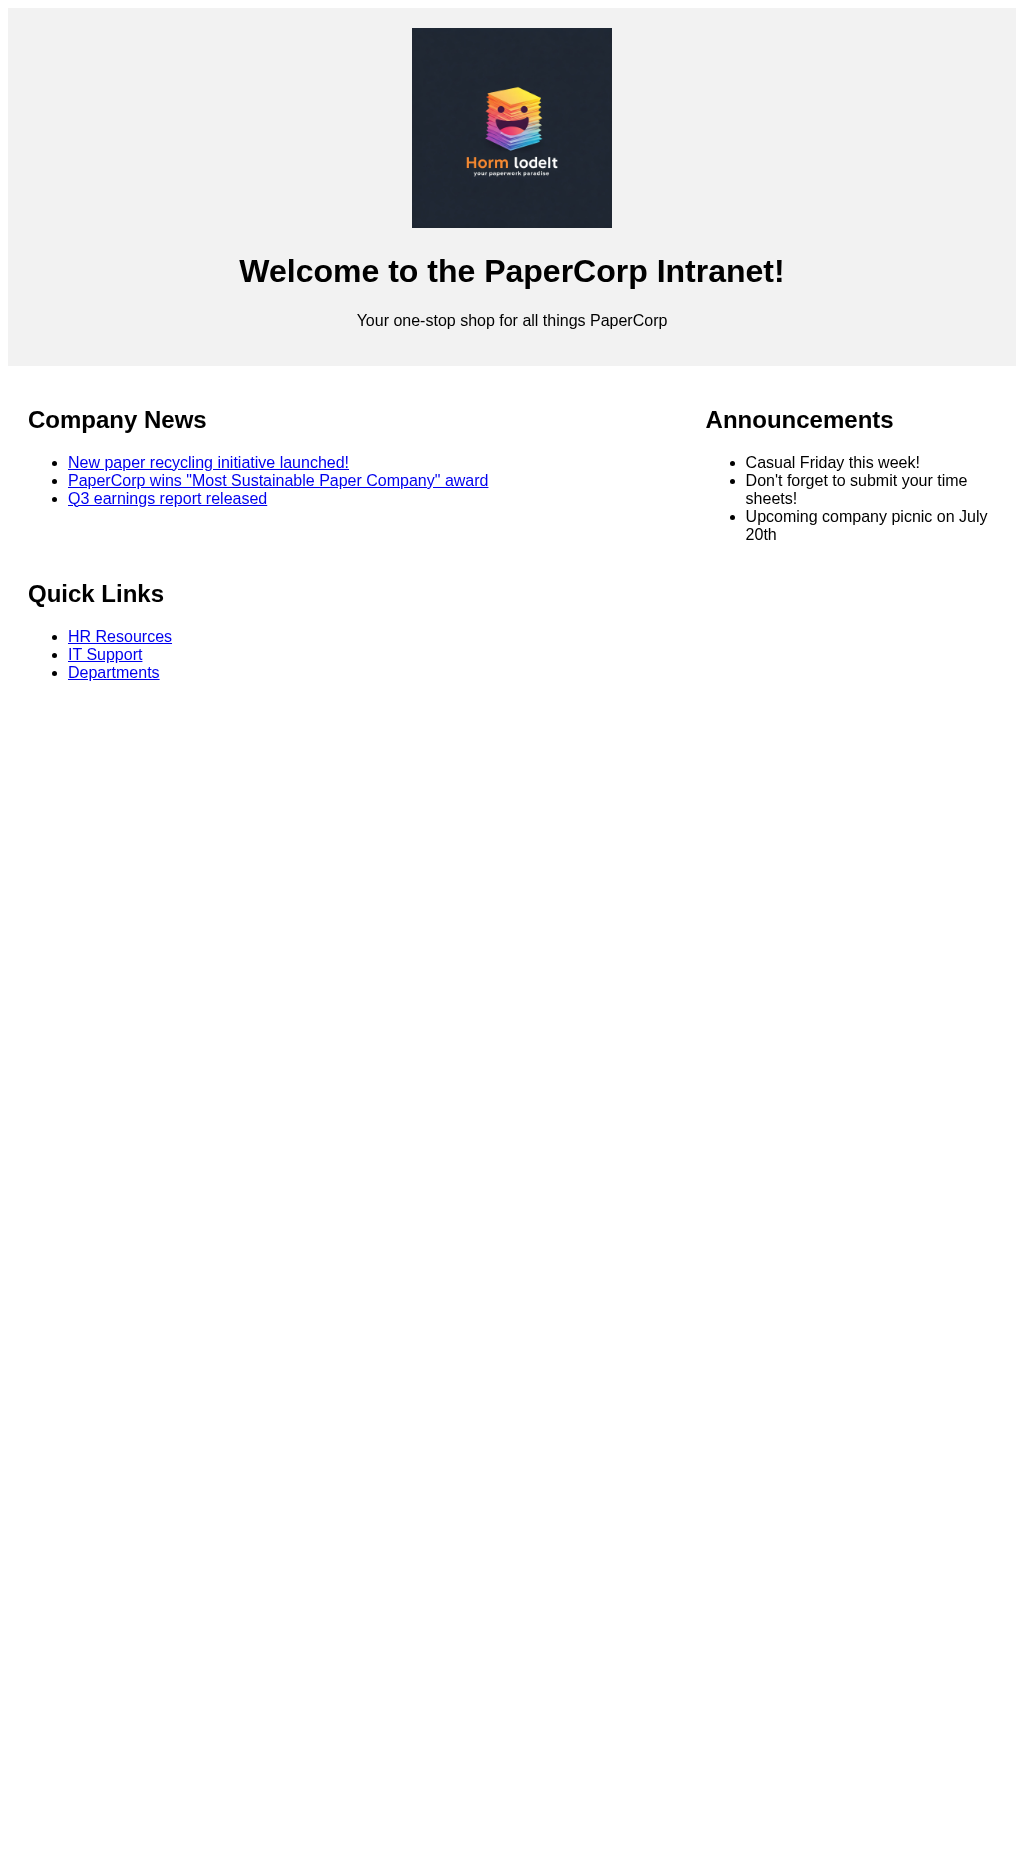

In [73]:
import PIL

print(browse_url(f"http://papercorp:{PORT}/"))
PIL.Image.open(SCREENSHOT_FILE)

Finally, start a chat that uses the `load_page` tool. Include instructions on how to access and navigate the intranet.

Note: If the data you provide to the model is at all sensitive, be sure to read and understand [the terms and conditions](https://ai.google.dev/gemini-api/terms#data-use-unpaid) for the Gemini API, specifically the terms governing how data is processed for paid vs unpaid services.

In [74]:
config = {
    'system_instruction': """Use the tools you have to answer the user's questions about
the "PaperCorp" company.

You have access to web pages through the `load_page` tool, including access to the local
network and intranet, where you will find information about the company. The `load_page`
tool will return you the page contents as Markdown.

The intranet hostname is `papercorp`, and the home page can be accessed via
http://papercorp/.

Unless you know an address already, start navigating from the home page to find other
pages.
""",
    'tools': [load_page],
}

chat = client.chats.create(model=MODEL, config=config)
r = chat.send_message('What forms are available through HR?')
show_parts(r)

127.0.0.1 - - [04/Nov/2025 12:55:55] "GET /robots.txt HTTP/1.1" 200 -
127.0.0.1 - - [04/Nov/2025 12:55:55] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Nov/2025 12:55:57] "GET /robots.txt HTTP/1.1" 200 -
127.0.0.1 - - [04/Nov/2025 12:55:57] "GET /hr.html HTTP/1.1" 200 -


The forms available through HR are:

*   Expense Report Form
*   Time Off Request Form
*   Benefits Enrollment Form
*   Tax Forms (W-2, etc.)

In [76]:
httpd.shutdown()
httpd.server_close()

## Further reading

* To learn more about using the grounding tools (search grounding, YouTube links and URL context), check out the [Grounding](../quickstarts/Grounding.ipynb) notebook or the one dedicated to [Seach grounding](../quickstarts/Search_Grounding.ipynb).
* For more advanced examples of function calling in the Live API, try the [Plotting and Mapping](../examples/LiveAPI_plotting_and_mapping.ipynb) cookbook recipe.

Or browse the [Gemini API cookbook](http://github.com/google-gemini/cookbook).